In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

### Data

In [2]:
# Random seed
np.random.seed(123)

# Generate a sequence with 100 numbers
sequence_length = 100
sequence = np.zeros(sequence_length)

means = [50, 30, 60, 40]                # Define the means for the 4 segments
segment_lengths = [25, 25, 25, 25]      # Define the lengths of the segments

# Populate the sequence with segments having different means
start_index = 0
for mean, length in zip(means, segment_lengths):
    end_index = start_index + length
    sequence[start_index:end_index] = np.random.normal(loc=mean, scale=5, size=length)
    start_index = end_index

# Labels
neg_start = [5, 55]
neg_end   = [15, 65]
pos_start = [20, 70]
pos_end   = [30, 80]

In [3]:
def plot_sequence(sequence, neg_start, neg_end, pos_start, pos_end, mean=None, lda=None):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set the figure title
    if(lda is not None):
        fig.suptitle('lambda = ' + str(lda))

    # Plot the regions
    bounds = (np.min(sequence) - 10, np.max(sequence) + 10)
    for start, end in zip(neg_start, neg_end):
        ax.fill_betweenx(bounds, start, end, color='pink', alpha=0.5, label='negative region')

    for start, end in zip(pos_start, pos_end):
        ax.fill_betweenx(bounds, start, end, color='red', alpha=0.5, label='positive region')

    # Plot the sequence
    ax.plot(sequence, marker='o', color='blue', label='sequence')

    # Plot the mean
    if(mean is not None):
        ax.plot(mean, color='green', label='mean')

    # Set axis labels
    ax.set_xlabel('point')
    ax.set_ylabel('value')

    # Set limit
    ax.set_xlim(-5, len(sequence) + 5)
    ax.set_ylim(bounds)

    # show legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = list(set(labels))
    unique_handles = [handles[labels.index(label)] for label in unique_labels]
    ax.legend(unique_handles, unique_labels)

    # Show the plot
    plt.show()

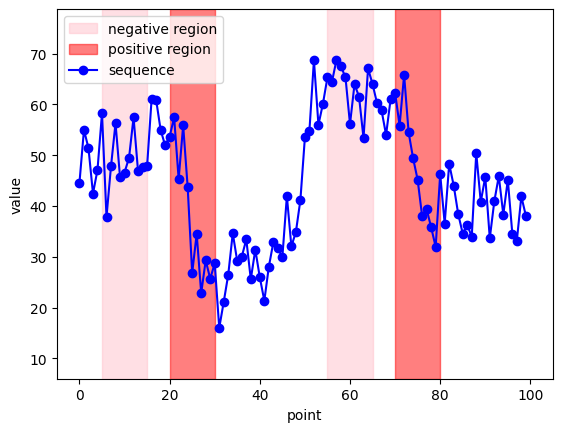

In [4]:
plot_sequence(sequence, neg_start, neg_end, pos_start, pos_end)

### OPART

In [5]:
# def L(start, end, x):
#     # get the segment
#     seg = x[start-1:end]

#     # get the value of mu
#     mu = np.mean(seg)

#     # return loss value
#     return np.sum(np.square(mu - seg))

In [6]:
def L(start, end, x):
    # get the segment
    seg = x[start-1:end]

    # cumulative sum
    z = np.sum(np.square(seg))
    y = np.sum(seg)
    return z - np.square(y)/(end-start+1)

In [7]:
# get the list of changepoint from vector tau_star
def trace_back(tau_star):
    tau = tau_star[-1]
    chpnt = np.array([len(tau_star)], dtype=int)
    while tau > 0:
        chpnt = np.append(tau, chpnt)
        tau = tau_star[tau]
    return np.append(0, chpnt)

In [8]:
# get the mean vector of the sequence from the list of changepoint
def get_mean(sequence, chpnt):
    mean = np.zeros(len(sequence))
    for i in range(len(chpnt)-1):
        mean[chpnt[i]:chpnt[i+1]] = np.mean(sequence[chpnt[i]:chpnt[i+1]])
    return mean

In [9]:
# opart dynamic algorithm
def opart(lda, x):
    # Set up
    C = np.zeros(len(x))
    C[0] = -lda

    # Get tau_star
    tau_star = np.zeros(len(x), dtype=int)
    for i in range(1, len(x)):

        # get set of possible changepoint
        po_chpnt = np.arange(i)

        # get set of possible value
        V = np.zeros(len(po_chpnt))
        for j in po_chpnt:
            V[j] = C[j] + lda + L(j+1, i, x)

        # get optimal tau from set V
        last_chpnt = np.argmin(V)

        # update C_i
        C[i] = V[last_chpnt]

        # update tau_star
        tau_star[i] = last_chpnt

    return trace_back(tau_star)

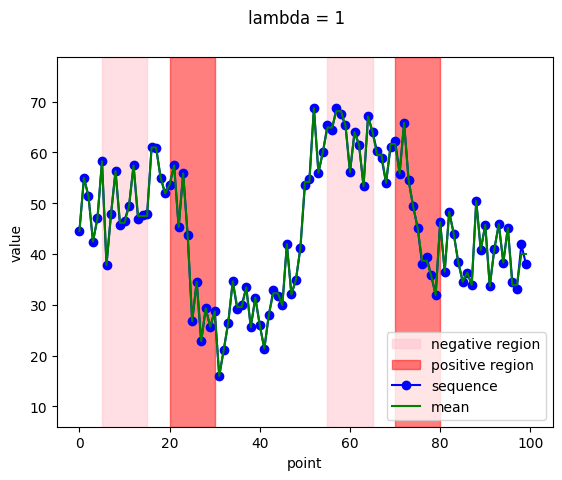

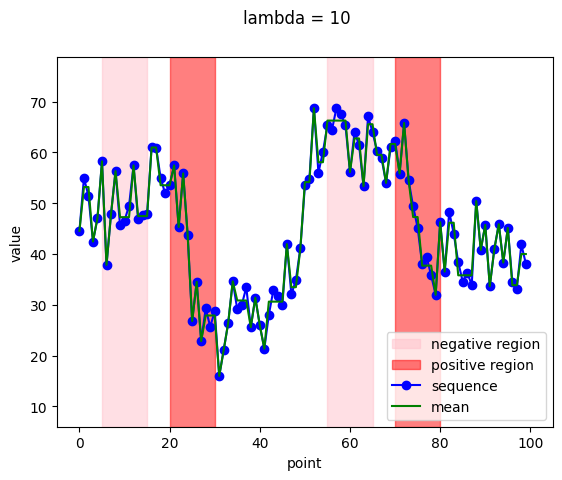

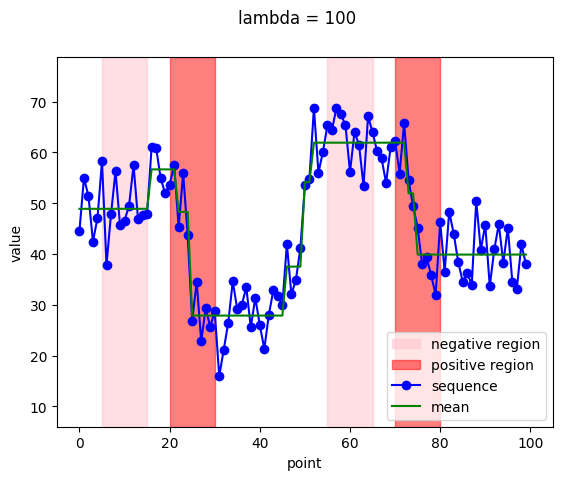

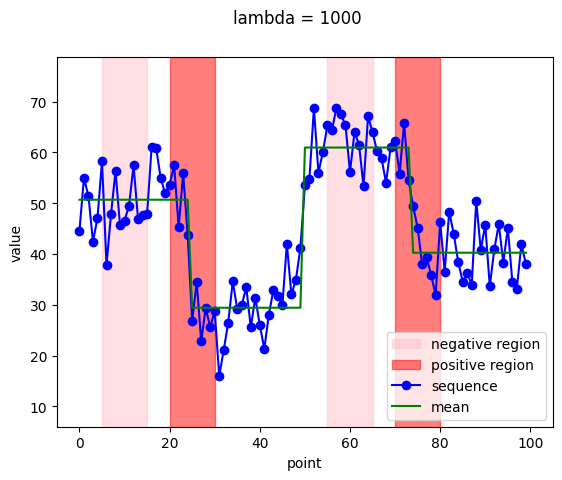

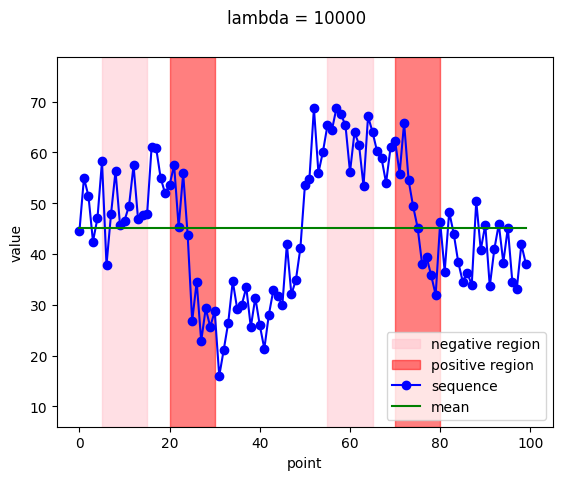

In [10]:
# plot solution with respect to different lambda
for lda in [1, 10, 100, 1000, 10000]:
    chpnt = opart(lda, sequence)
    mean  = get_mean(sequence, chpnt)
    plot_sequence(sequence, neg_start, neg_end, pos_start, pos_end, mean, lda)